In [2]:
import os
import sys
import math
import re

import fnmatch

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

In [3]:
ddir = '/disk1/data1/data/px_he2/images/'

In [9]:
def getSortKey(val):
    return val[0]
  
#Read all required file as a sorted array 
def gather_dataset():
    file_pattern = 'IDRiD_*_pi*.npy'
    files = os.listdir(ddir)
    m_files = []
    i=0
    for filename in files:
        #if i > 5:
        #    break
        #print(fnmatch.fnmatch(filename, file_pattern))
        if fnmatch.fnmatch(filename, file_pattern):
            #print(filename)
            m = re.findall('^(.*?)_(\d+)_(\d+)_.*?$',filename)
            if m:
                #print(m[0][1])
                m_files.append(((int(m[0][1])*100000)+int(m[0][2]),m[0][1],filename,m[0][0]+'_'+m[0][1]+'_'+m[0][2]+'.jpg'))
            i += 1
        #print('File: {}\t: {}'.format(filename, type(fnmatch.fnmatch(filename, file_pattern))))
    #print(m_files[:5])
    m_files.sort(key=getSortKey)
    print(m_files[-5:])
    
    return m_files
    
#temp = gather_dataset()
#print(temp[:5])


In [5]:
#patches is array of all images patches [<no_patches>,<patch_size>,<patch_size>,<channels>]
#image_size is width or height of square image
#number channels
def reconstruct_patches(patches,patch_size,image_size,channels):
  # getinitial data
  p = patch_size #patch size
  h = image_size #image size
  c = channels #image channels
  pad = [[0,0],[0,0]]
  hbyp = int(h/p)

  # Do processing on patches
  # Using patches here to reconstruct
  '''
  patches_proc = tf.reshape(patches,[1,h/p,h/p,p*p,c])
  patches_proc = tf.split(patches_proc,p*p,3)
  patches_proc = tf.stack(patches_proc,axis=0)
  patches_proc = tf.reshape(patches_proc,[p*p,h/p,h/p,c])
  '''
  patches_proc = tf.reshape(patches,[1,hbyp,hbyp,p*p,c])
  patches_proc = tf.split(patches_proc,p*p,3)
  patches_proc = tf.stack(patches_proc,axis=0)
  patches_proc = tf.reshape(patches_proc,[p*p,hbyp,hbyp,c])

  reconstructed_image = tf.batch_to_space_nd(patches_proc,[p, p],pad)

  return reconstructed_image



In [6]:
#display patches
def show_image_grid(images: list, img_names: list,img_per_row: int = 2) -> None:
    n: int = len(images)
    n_cols = int(n/img_per_row)
    print_size = int(images[0].shape[0]/10)
    f = plt.figure(figsize=(print_size,print_size))
    print("#images[%d] n_rows[%d] n_cols[%d] print_size[%d]" % (n,img_per_row,n_cols,print_size))
    for i in range(n):
        #for j in range(img_per_row):
        #print(i,img_per_row,n_cols)
        # Debug, plot figure
        f.add_subplot( n_cols, img_per_row, i+1)
        plt.title(img_names[i])
        plt.axis('off')
        #plt.imshow(images[(i*img_per_row+j)])
        plt.imshow(images[i])
    plt.show(block=True)

In [10]:
#recontruct original image from patches...only works with non overlapping stride patches
def process_img_patches(img_id,patch_filename_arr):
    #print("***processing img_id[",img_id,"] ",len(patch_arr),patch_arr[0],patch_arr[-1])
    
    #do some initial calculations to set patch_size, no_patches and image_size
    channels = 1
    no_patches = len(patch_filename_arr)
    patch0 = np.load(ddir + patch_filename_arr[0])
    patch_size = patch0.shape[0]
    if len(patch0.shape) > 2:
        channels = int(3)
    else:
        channels = int(1)
    image_size = int(math.sqrt(no_patches*patch_size*patch_size))
    print("img[%s] no_patches[%d] patch_size[%d] channels[%d] image_size[%d]" % 
              (img_id,no_patches,patch_size,channels,image_size))
    
    buf = np.zeros((no_patches,patch_size,patch_size,channels),dtype=np.uint8)
    for i in range(no_patches):
        if channels > 1:
            buf[i,:,:,:] = np.load(ddir + patch_filename_arr[i])
        else:
            tmpbuf = np.load(ddir + patch_filename_arr[i])
            tmpbuf = np.reshape(tmpbuf,(patch_size,patch_size,channels))
            buf[i,:,:,:] = tmpbuf
            
    patches = tf.convert_to_tensor(buf,dtype=tf.int32)
    print(type(patches),type(patch_size),type(image_size),type(channels),buf.shape)
    reconstructed_image = reconstruct_patches(patches,
                                              patch_size,
                                              image_size,
                                              channels)
    
    with tf.Session() as sess:
        ri = sess.run(reconstructed_image)
        #print(type(ri),buf.shape,ri.shape)
    
    return np.reshape(ri,(image_size,image_size,channels))

[(8101595, '81', 'IDRiD_81_1595_pi.jpg.npy', 'IDRiD_81_1595.jpg'), (8101596, '81', 'IDRiD_81_1596_pi.jpg.npy', 'IDRiD_81_1596.jpg'), (8101597, '81', 'IDRiD_81_1597_pi.jpg.npy', 'IDRiD_81_1597.jpg'), (8101598, '81', 'IDRiD_81_1598_pi.jpg.npy', 'IDRiD_81_1598.jpg'), (8101599, '81', 'IDRiD_81_1599_pi.jpg.npy', 'IDRiD_81_1599.jpg')]
IDRiD_76_17_pi.jpg.npy IDRiD_76_17.jpg
#images[3] n_rows[3] n_cols[1] print_size[12]


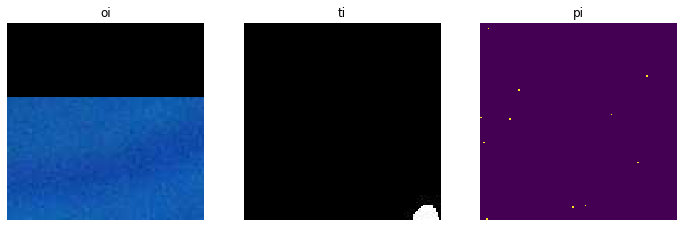

IDRiD_76_18_pi.jpg.npy IDRiD_76_18.jpg
#images[3] n_rows[3] n_cols[1] print_size[12]


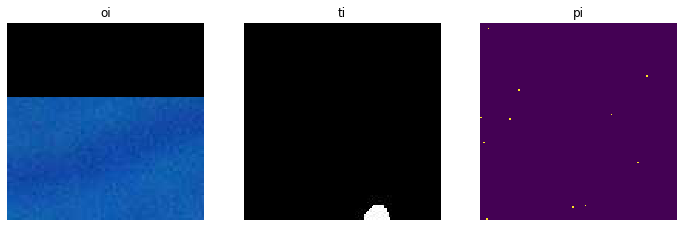

IDRiD_76_19_pi.jpg.npy IDRiD_76_19.jpg
#images[3] n_rows[3] n_cols[1] print_size[12]


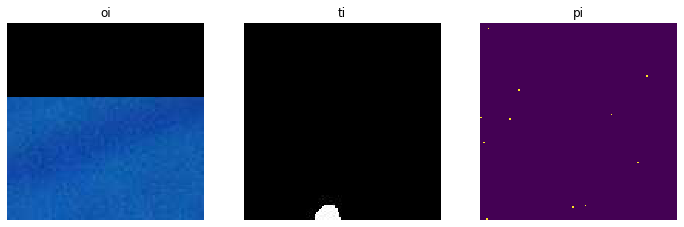

IDRiD_76_20_pi.jpg.npy IDRiD_76_20.jpg
#images[3] n_rows[3] n_cols[1] print_size[12]


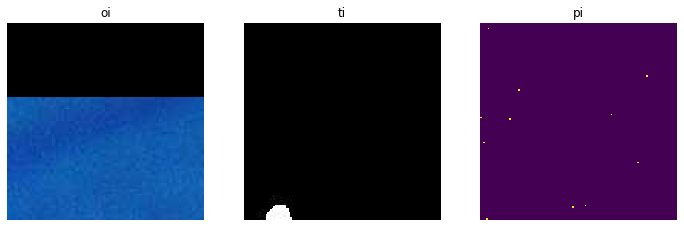

IDRiD_76_97_pi.jpg.npy IDRiD_76_97.jpg
#images[3] n_rows[3] n_cols[1] print_size[12]


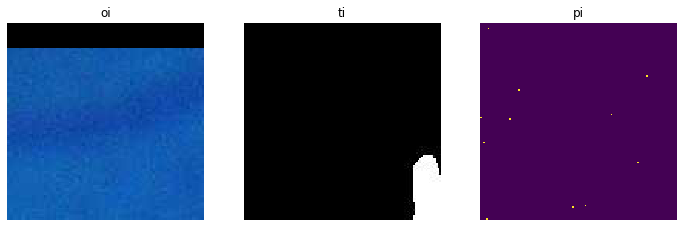

IDRiD_76_98_pi.jpg.npy IDRiD_76_98.jpg
#images[3] n_rows[3] n_cols[1] print_size[12]


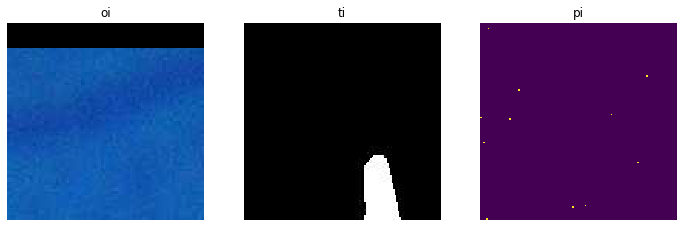

IDRiD_76_99_pi.jpg.npy IDRiD_76_99.jpg
#images[3] n_rows[3] n_cols[1] print_size[12]


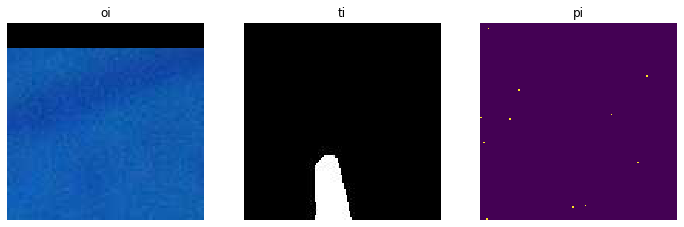

IDRiD_76_100_pi.jpg.npy IDRiD_76_100.jpg
#images[3] n_rows[3] n_cols[1] print_size[12]


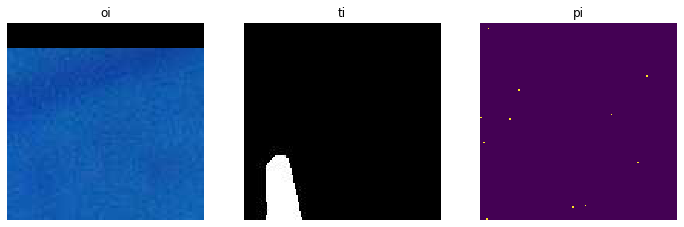

IDRiD_76_101_pi.jpg.npy IDRiD_76_101.jpg
#images[3] n_rows[3] n_cols[1] print_size[12]


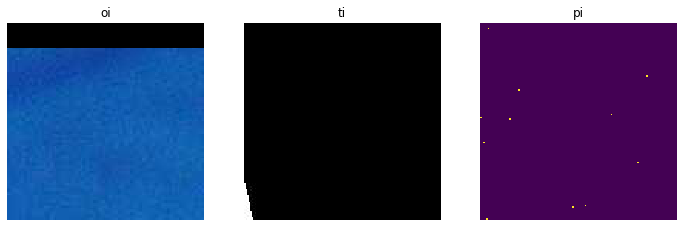

IDRiD_76_177_pi.jpg.npy IDRiD_76_177.jpg
#images[3] n_rows[3] n_cols[1] print_size[12]


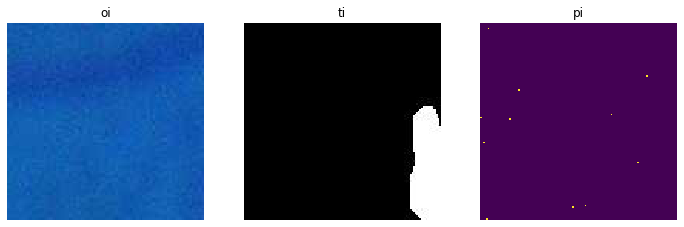

IDRiD_76_178_pi.jpg.npy IDRiD_76_178.jpg
#images[3] n_rows[3] n_cols[1] print_size[12]


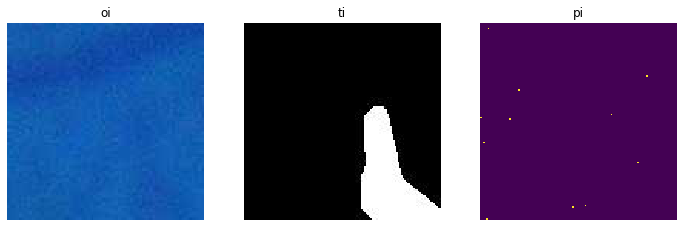

IDRiD_76_179_pi.jpg.npy IDRiD_76_179.jpg
#images[3] n_rows[3] n_cols[1] print_size[12]


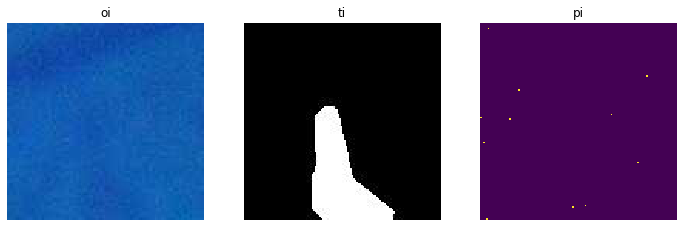

IDRiD_76_180_pi.jpg.npy IDRiD_76_180.jpg
#images[3] n_rows[3] n_cols[1] print_size[12]


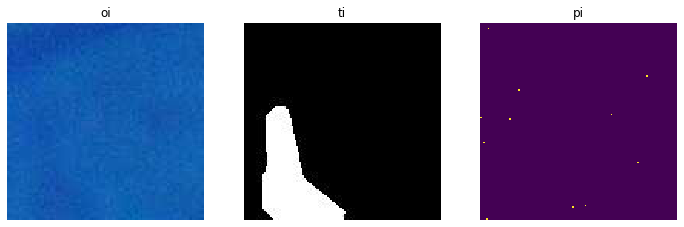

IDRiD_76_181_pi.jpg.npy IDRiD_76_181.jpg
#images[3] n_rows[3] n_cols[1] print_size[12]


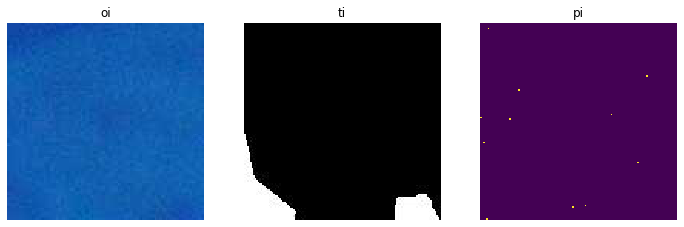

IDRiD_76_182_pi.jpg.npy IDRiD_76_182.jpg
#images[3] n_rows[3] n_cols[1] print_size[12]


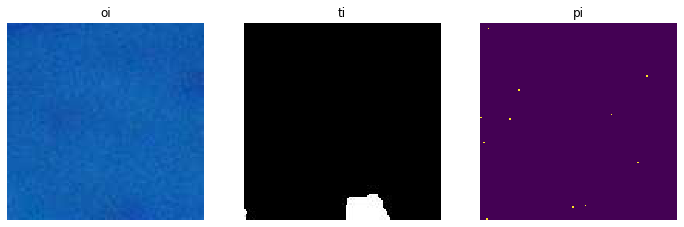

IDRiD_76_183_pi.jpg.npy IDRiD_76_183.jpg
#images[3] n_rows[3] n_cols[1] print_size[12]


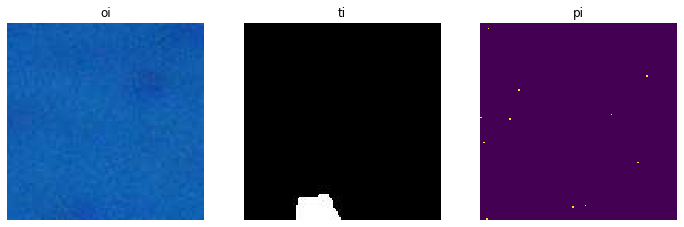

IDRiD_76_184_pi.jpg.npy IDRiD_76_184.jpg
#images[3] n_rows[3] n_cols[1] print_size[12]


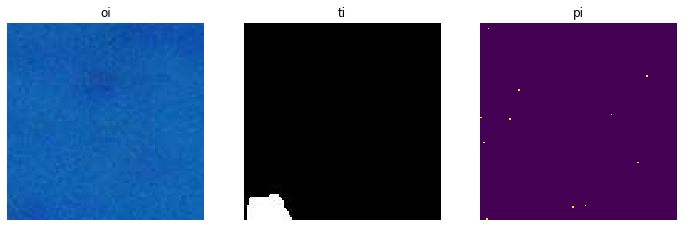

IDRiD_76_257_pi.jpg.npy IDRiD_76_257.jpg
#images[3] n_rows[3] n_cols[1] print_size[12]


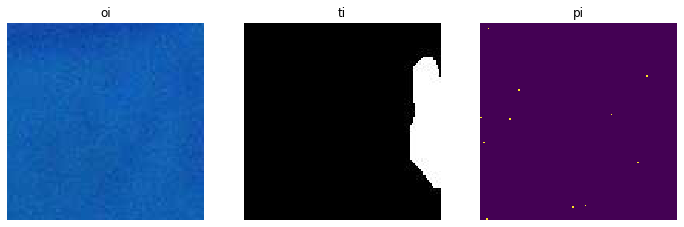

IDRiD_76_258_pi.jpg.npy IDRiD_76_258.jpg
#images[3] n_rows[3] n_cols[1] print_size[12]


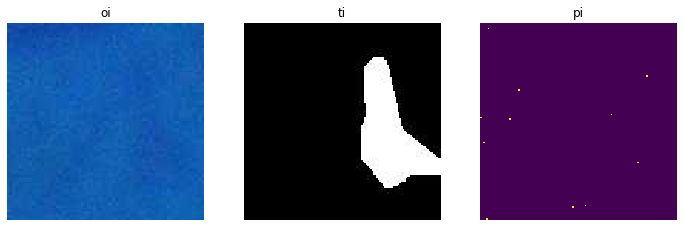

IDRiD_76_259_pi.jpg.npy IDRiD_76_259.jpg
#images[3] n_rows[3] n_cols[1] print_size[12]


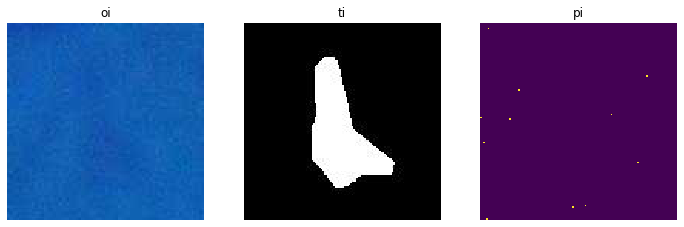

IDRiD_76_260_pi.jpg.npy IDRiD_76_260.jpg
#images[3] n_rows[3] n_cols[1] print_size[12]


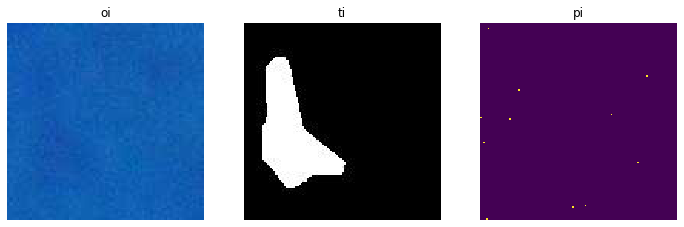

In [18]:
imgdir = ddir 
gtdir = ddir + '../gt/'

def check_results():
    patch_recs = gather_dataset()
    #print(patch_recs[:5])
    i = 0
    patch_filename_arr = []
    prev_img_id = 'DontMatch'
    for patch_rec in patch_recs:
        if i > 20:
            break
        img_id = patch_rec[1]
        pi_patch_filename = patch_rec[2]
        oi_patch_filename = patch_rec[3]
        
        print(pi_patch_filename,oi_patch_filename)
        
        pi_img = np.load(ddir + pi_patch_filename)
        oi_img = plt.imread(imgdir + oi_patch_filename)
        ti_img = plt.imread(gtdir + oi_patch_filename)
        
        pi_img[pi_img>=.5] = 255 
        pi_img[pi_img<.5] = 0 
        #pi_img *= 255
        
        show_image_grid([oi_img,ti_img,pi_img],['oi','ti','pi'],img_per_row=3)
        
        i += 1

check_results()

In [25]:

    
def process_pi_patches():
    patch_recs = gather_dataset()
    #print(patch_recs[:5])
    i = 0
    patch_filename_arr = []
    prev_img_id = 'DontMatch'
    for patch_rec in patch_recs:
        img_id = patch_rec[1]
        patch_filename = patch_rec[2]
        
        #for first iteration 
        if i == 0:
            prev_img_id = img_id
            
        if img_id != prev_img_id:
            ri = process_img_patches(prev_img_id,patch_filename_arr)
            np.save(ddir + 'IDRiD_' + prev_img_id + '_pi.npy',ri)
            patch_filename_arr = []
            
        patch_filename_arr.append(patch_filename)
        prev_img_id = img_id
        #print(id,patch_filename)
        #print(patch_rec)
        i += 1
    ri = process_img_patches(prev_img_id,patch_filename_arr)
    np.save(ddir + 'IDRiD_' + prev_img_id + '_pi.npy',ri)
    '''
    o_img = tf.convert_to_tensor(u_image,dtype=tf.uint8)
    print("o_img tensor shape [{}]".format(tf.shape(o_img)))
    patches = get_img_patches( o_img, patch_size)
    reconstructed_image = reconstruct_patches(patches,patch_size,tf.shape(o_img)[1],tf.shape(o_img)[3])
    '''
    return True

temp = process_pi_patches()

[(8101595, '81', 'IDRiD_81_1595_pi.jpg.npy'), (8101596, '81', 'IDRiD_81_1596_pi.jpg.npy'), (8101597, '81', 'IDRiD_81_1597_pi.jpg.npy'), (8101598, '81', 'IDRiD_81_1598_pi.jpg.npy'), (8101599, '81', 'IDRiD_81_1599_pi.jpg.npy')]
img[78] no_patches[6400] patch_size[128] channels[1] image_size[10240]
<class 'tensorflow.python.framework.ops.Tensor'> <class 'int'> <class 'int'> <class 'int'> (6400, 128, 128, 1)
img[79] no_patches[1600] patch_size[128] channels[1] image_size[5120]
<class 'tensorflow.python.framework.ops.Tensor'> <class 'int'> <class 'int'> <class 'int'> (1600, 128, 128, 1)
img[80] no_patches[1600] patch_size[128] channels[1] image_size[5120]
<class 'tensorflow.python.framework.ops.Tensor'> <class 'int'> <class 'int'> <class 'int'> (1600, 128, 128, 1)
img[81] no_patches[1600] patch_size[128] channels[1] image_size[5120]
<class 'tensorflow.python.framework.ops.Tensor'> <class 'int'> <class 'int'> <class 'int'> (1600, 128, 128, 1)


(10240, 10240, 1) [0 0 0 0 0]
(10240, 10240) [0 0 0 0 0]
(10240, 10240) [0 0 0 0 0]


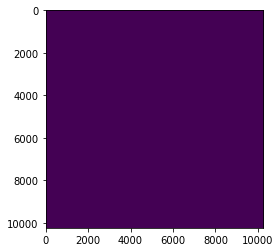

In [8]:
pi_img_id_arr = ['78','80','81']
t_img = np.load(ddir + 'IDRiD_' + pi_img_id_arr[0] + '_pi.npy')
print(t_img.shape,t_img[0,:5,0])
t_img = np.reshape(t_img,(t_img.shape[0],t_img.shape[1]))
print(t_img.shape,t_img[0,:5])
t_img = (t_img*255).astype(np.uint8)
print(t_img.shape,t_img[0,:5])
plt.imshow(t_img)
#show_image_grid([t_img],[pi_img_id_arr[0]],img_per_row=1)

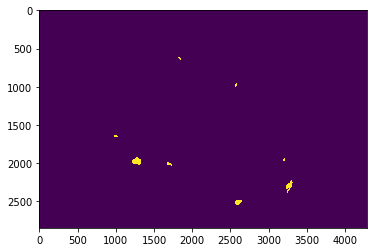

In [125]:
pi_img_id_arr = ['73','74']
img_path = '/disk1/data1/data/idrid/ex/gt/' + 'IDRiD_' + pi_img_id_arr[0] + '_HE.jpg'
t_img = plt.imread(img_path)
plt_img = plt.imshow(t_img)

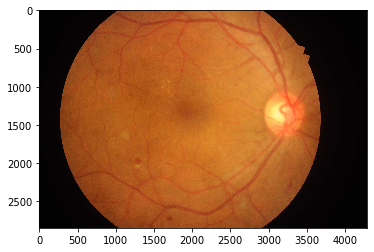

In [126]:
pi_img_id_arr = ['73','74']
img_path = '/disk1/data1/data/idrid/ex/images/' + 'IDRiD_' + pi_img_id_arr[0] + '.jpg'
t_img = plt.imread(img_path)
plt_img = plt.imshow(t_img)